In [1]:
import copy

import pandas as pd
import rdkit
from molfeat.trans import FPVecTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AtomValenceException, Descriptors

from utils import smiles_to_mol, get_ecfp4_count_fingerprint, get_chembl_drugs

[11:39:39] Initializing Normalizer


In [2]:
## Evaluation of common algorithms when trained 

In [2]:
df_b3db_kc = pd.read_csv("b3db_kc_split.tsv", sep="\t")
df_b3db_kc["mol"] = df_b3db_kc.smiles.apply(smiles_to_mol)
df_train = df_b3db_kc[df_b3db_kc.split == "training"].copy()
df_test = df_b3db_kc[df_b3db_kc.split == "test"].copy()
print(f"Read {len(df_b3db_kc)} records, {len(df_train)} in training, and {len(df_test)} in test splits.")

Read 3322 records, 2677 in training, and 645 in test splits.


In [3]:
# Generation of the B3DB training set for comparison. This is achieved by excluding scaffolds  
df_b3db = pd.read_csv("../data/B3DB/B3DB/B3DB_classification.tsv", sep="\t")
print(f"Read {len(df_b3db)} B3DB classification records")
df_b3db["mol"] = df_b3db.SMILES.apply(smiles_to_mol)
_n_pre_removal = len(df_b3db)
df_b3db = df_b3db[df_b3db.mol.apply(pd.notna)]
print(f"Removed {_n_pre_removal - len(df_b3db)} B3DB molecules with non-parsable SMILES ({_n_pre_removal} -> {len(df_b3db)})")
_n_pre_removal = len(df_b3db)
df_b3db = df_b3db[df_b3db.mol.apply(Descriptors.ExactMolWt) <= 1000]
print(f"Removed {_n_pre_removal - len(df_b3db)} molecules with MolWt > 1000 Da ({_n_pre_removal} -> {len(df_b3db)})")

df_drugs = get_chembl_drugs()
print(f"Acquired {len(df_drugs)} ChEMBL drugs")
def _get_murcko_scaffold_or_none(smi):
    try:
        return rdkit.Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles(smi)
    except AtomValenceException:
        return None
    
df_b3db["murcko_scaffold"] = df_b3db.SMILES.apply(_get_murcko_scaffold_or_none)
_n_pre_removal = len(df_b3db)
df_b3db = df_b3db[pd.notna(df_b3db.murcko_scaffold)]
print(f"Removed {_n_pre_removal - len(df_b3db)} B3DB entries for which we could not generate Murcko Scaffold ({_n_pre_removal} -> {len(df_b3db)})")
df_b3db["ecfp4_count_fingerprint"] = df_b3db.SMILES.apply(get_ecfp4_count_fingerprint)

df_test["murcko_scaffold"] = df_test.smiles.apply(rdkit.Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles)
df_test["ecfp4_count_fingerprint"] = df_test.smiles.apply(get_ecfp4_count_fingerprint)

scaffold_outlier_to_test_ecfp4_count_fingerprints = {so: set(df_test.ecfp4_count_fingerprint) for so in ["", "c1ccccc1",  "O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21"]}
outlier_similarity = 0.5

_s_test_scaffolds = set(df_test.murcko_scaffold)
print(len(_s_test_scaffolds), "test scaffolds")
print(len(set(df_b3db["murcko_scaffold"])) ," scaffolds in df_b3db")

def _b3db_in_test(row):
    if row.murcko_scaffold in scaffold_outlier_to_test_ecfp4_count_fingerprints:
        return any(
            DataStructs.TanimotoSimilarity(row.ecfp4_count_fingerprint, f) >= outlier_similarity 
            for f in scaffold_outlier_to_test_ecfp4_count_fingerprints[row.murcko_scaffold]
        )
    else:
        return row.murcko_scaffold in _s_test_scaffolds
    
df_b3db["scaffold_in_test"] = df_b3db.apply(axis=1, func=_b3db_in_test)
_s_b3db_test_scaffolds = set(df_b3db[df_b3db.scaffold_in_test].murcko_scaffold)
assert (len(_s_b3db_test_scaffolds) < len(_s_test_scaffolds))

df_b3db_train = df_b3db[df_b3db["scaffold_in_test"] == False]
print(f"Removed {len(df_b3db) - len(df_b3db_train)} B3DB entries with scaffolds in the test set ({len(df_b3db)} -> {len(df_b3db_train)})")

print("Positive / negative ratios")
_df = pd.DataFrame([
    {"dataset": "Test", "size": len(df_test), "n_positive": sum(df_test["BBB+/BBB-"] == "BBB+"), "n_negative": sum(df_test["BBB+/BBB-"] == "BBB-")},    
    {"dataset": "Training", "size": len(df_train),"n_positive": sum(df_train["BBB+/BBB-"] == "BBB+"), "n_negative": sum(df_train["BBB+/BBB-"] == "BBB-")},
    {"dataset": "B3DB Training", "size": len(df_b3db_train), "n_positive": sum(df_b3db_train["BBB+/BBB-"] == "BBB+"), "n_negative": sum(df_b3db_train["BBB+/BBB-"] == "BBB-") },
])
_df["p/n_ratio"] = _df.n_positive / _df.n_negative
_df["p/n_ratio"] = _df["p/n_ratio"].apply(lambda x: round(x, 3))
_df

Read 7807 B3DB classification records
Removed 2 B3DB molecules with non-parsable SMILES (7807 -> 7805)
Removed 86 molecules with MolWt > 1000 Da (7805 -> 7719)
Acquired 4153 ChEMBL drugs
Removed 0 B3DB entries for which we could not generate Murcko Scaffold (7719 -> 7719)
328 test scaffolds
2096  scaffolds in df_b3db
Removed 1693 B3DB entries with scaffolds in the test set (7719 -> 6026)
Positive / negative ratios


,dataset,size,n_positive,n_negative,p/n_ratio
0,Test,645,418,227,1.841
1,Training,2677,1697,980,1.732
2,B3DB Training,6026,3703,2323,1.594


In [29]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import get_scorer, average_precision_score, make_scorer
from sklearn.linear_model import LogisticRegression

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import AdaBoostClassifier
# 
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.dummy import DummyClassifier


def get_classification_models():
    return [
        #DummyClassifier(random_state=42),
        LogisticRegression(random_state=42, max_iter=1000, solver="liblinear"),
        #SVC(random_state=42),
        #SGDClassifier(random_state=42),
        #GaussianNB(),
        #DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        #ExtraTreesClassifier(random_state=42),
        #AdaBoostClassifier(random_state=42),
        XGBClassifier(random_state=42),
]

featurisers = [
    #("ecfp", False),
    ("ecfp-count", False),
    #("avalon", False),
    ("maccs", False),
    #("desc3D", True),
    ("desc2D", False),
    #("mordred", False),  # During the run, this got un-workably slow.
    #("cats2D", False),
    #("cats3D", True),
    #("pharm2D", False),
    #("pharm3D", True),
    #("skeys", False),
    #("electroshape", True)
]

_test_labels = df_test["BBB+/BBB-"].apply(lambda x: 1 if x == "BBB+" else 0)
metrics_classification = ["accuracy", "balanced_accuracy", "precision", "recall", "f1", "pr_auc", "roc_auc", "druglike_ChEMBL"]

def evaluate_classification(df_train, df_train_b3db) -> pd.DataFrame:
    res = []
    _train_labels = df_train["BBB+/BBB-"].apply(lambda x: 1 if x == "BBB+" else 0)
    _train_labels_b3db = df_train_b3db["BBB+/BBB-"].apply(lambda x: 1 if x == "BBB+" else 0) 

    for f, uses_3d in featurisers[:]:    
        print(f)
        transformer = FPVecTransformer(kind=f, dtype=float, n_jobs=16, verbose=True)
        m_col = "mol_conformers" if uses_3d else "mol"
        _df_desc_test = pd.DataFrame(transformer(df_test[m_col]), columns=transformer.columns).dropna(axis=1)
        _df_desc_test = _df_desc_test.loc[:, ~_df_desc_test.columns.duplicated(keep='first')]

        _df_desc_train = pd.DataFrame(transformer(df_train[m_col]), columns=transformer.columns).dropna(axis=1)
        _df_desc_train = _df_desc_train.loc[:, ~_df_desc_train.columns.duplicated(keep='first')]

        _df_desc_b3db_train = pd.DataFrame(transformer(df_train_b3db[m_col]), columns=transformer.columns).dropna(axis=1)
        _df_desc_b3db_train = _df_desc_b3db_train.loc[:, ~_df_desc_b3db_train.columns.duplicated(keep='first')]


        _s = set(_df_desc_test) & set(_df_desc_train) & set(_df_desc_b3db_train)
        if len(_s) != len(transformer.columns):
            print(f"    Removed {len(transformer.columns) - len(list(_df_desc_test))} descriptors not shared across training and test sets")
        _sl = [c for c in _df_desc_test if c in _s]
        _df_desc_test = _df_desc_test[_sl]
        _df_desc_train = _df_desc_train[_sl]
        _df_desc_b3db_train = _df_desc_b3db_train[_sl]

        _df_desc_drugs = pd.DataFrame(transformer(df_drugs["mol_conformers" if uses_3d else "mol"]), columns=transformer.columns)
        _n_pre_removal = len(_df_desc_drugs)
        _df_desc_drugs = _df_desc_drugs.dropna(axis=0, subset=_sl)[_sl]
        if _n_pre_removal != len(_df_desc_drugs):
            print(f"Removed {_n_pre_removal - len(_df_desc_drugs)} drugs for which all required descriptors could not be calculated")
        _df_desc_drugs = _df_desc_drugs.loc[:, ~_df_desc_drugs.columns.duplicated(keep='first')]


        def _drugs_ratio(model, _, __):
            return round(sum(model.predict(_df_desc_drugs)) / len(_df_desc_drugs), 3)

        _pr_auc_scorer = make_scorer(average_precision_score,  response_method="predict_proba")

        for mod in get_classification_models()[:]:
            print("  " + mod.__class__.__name__)
            mod_train = copy.deepcopy(mod)
            mod_train.fit(_df_desc_train, _train_labels)

            mod_b3db = copy.deepcopy(mod)
            mod_b3db.fit(_df_desc_b3db_train, _train_labels_b3db)
            for _met in metrics_classification:
                _met_scorer = _drugs_ratio if _met == "druglike_ChEMBL" else _pr_auc_scorer if _met == "pr_auc" else get_scorer(_met)
                _v = _met_scorer(mod_train, _df_desc_test, _test_labels)
                _v_b3db = _met_scorer(mod_b3db, _df_desc_test, _test_labels)
                res.append({
                    "model": mod.__class__.__name__,
                    "featuriser": f,
                    "metric": _met,
                    "value": _v,
                    "value_b3db": _v_b3db,
                    "value_change": _v - _v_b3db,
                })

    return pd.DataFrame(res)

def plot_changes_heatmap(df_results, title, save_figure_as):
    """
    :param df_results: A dataframe with the following columns:
       - model
       - featuriser
       - metric
       - value
       - value_b3db
       - value_change
    """
    df_results['model_featuriser'] = df_results['model'] + '\n' + df_results['featuriser']
    pivot_df = df_results.pivot(index='model_featuriser', columns='metric', values='value_change')
    pivot_df = pivot_df[metrics_classification]
    no_colour_mask = (pivot_df > -0.005) & (pivot_df < 0.005)
    cmap = sns.diverging_palette(20, 220, as_cmap=True)
    cmap.set_bad('white')  
    plt.figure(figsize=(10, 6))
    
    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(pivot_df, annot=False, fmt="", cmap=cmap, center=0,
                linewidths=.5, cbar_kws={"shrink": .5}, mask=no_colour_mask)
    cbar = ax.collections[0].colorbar
    cbar.set_label("Metric change", labelpad=10)
    
    # Loop over data dimensions and create text annotations with 'value' and 'value_b3db'
    for idx, row in df_results.iterrows():
        row_pos = list(pivot_df.index).index(row['model_featuriser'])
        col_pos = list(pivot_df.columns).index(row['metric'])
        plt.text(col_pos + 0.5, row_pos + 0.5, f"{round(row['value_b3db'],2)}\n{round(row['value'], 2)}", ha="center", va="center", color="black")
    
    plt.title(title, fontsize=15, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel("")
    plt.ylabel("Model Featurisers")

    plt.savefig('figures/' + save_figure_as, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

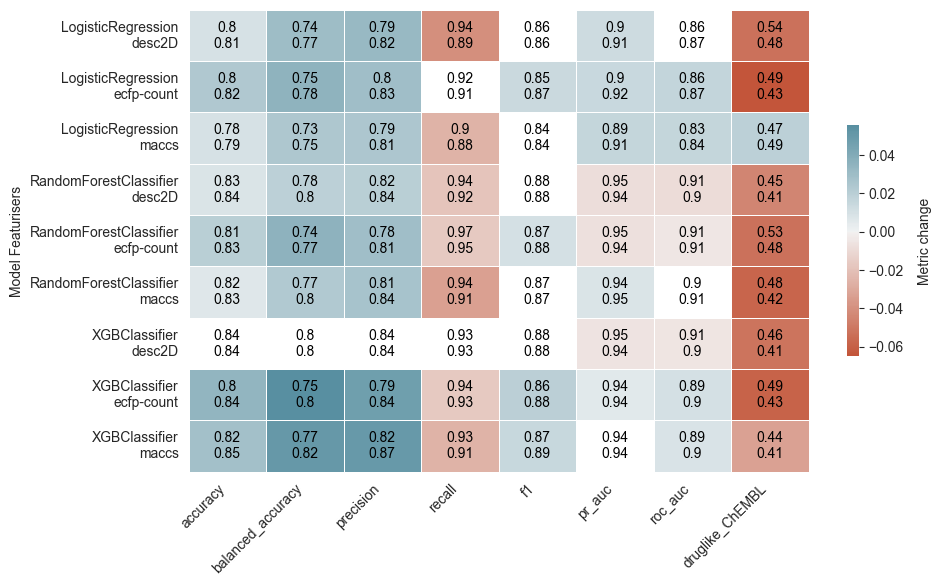

In [30]:
_df_results_classification = evaluate_classification(df_train, df_b3db_train)
plot_changes_heatmap(_df_results_classification, "", save_figure_as="figure_11.png") #"Changes of classification performance between the B3DB and this work")

ecfp-count
  LogisticRegression
  RandomForestClassifier
  XGBClassifier
maccs
  LogisticRegression
  RandomForestClassifier
  XGBClassifier
desc2D
    Removed 13 descriptors not shared across training and test sets


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
[12:19:47] Can't kekulize mol.  Unkekulized atoms: 3 10
[12:19:47] Can't kekulize mol.  Unkekulized atoms: 3 10
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


Removed 15 drugs for which all required descriptors could not be calculated
  LogisticRegression
  RandomForestClassifier
  XGBClassifier


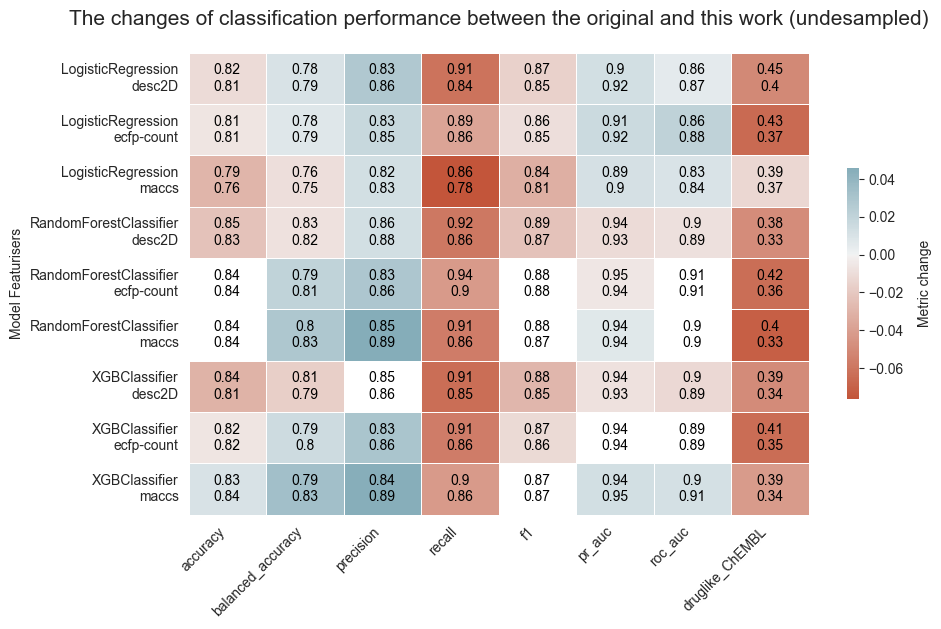

In [28]:
def _undersample_bbb_class(df):
    class_counts = df["BBB+/BBB-"].value_counts()
    min_class_size = class_counts.min()
    balanced_df = pd.DataFrame()
    for class_label in class_counts.index:
        class_subset = df[df["BBB+/BBB-"] == class_label]
        class_subset_sample = class_subset.sample(n=min_class_size, random_state=42)
        balanced_df = pd.concat([balanced_df, class_subset_sample], axis=0) 
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

df_train_us = _undersample_bbb_class(df_train)
df_b3db_train_us = _undersample_bbb_class(df_b3db_train) 
_df_results_classification_undersampled = evaluate_classification(df_train_us, df_b3db_train_us)
plot_changes_heatmap(_df_results_classification_undersampled, "The changes of classification performance between the original and this work (undesampled)")

### Direct model comparison
A direct, case-specific evaluation of the top-performing model (balanced accuracy).

In [11]:
classifier = XGBClassifier(random_state=42)
classifier_b3db = XGBClassifier(random_state=42)
transformer = FPVecTransformer(kind="ecfp-count", dtype=float, n_jobs=16, verbose=True)
_df_desc_test = pd.DataFrame(transformer(df_test["mol"]), columns=transformer.columns)
_df_desc_train = pd.DataFrame(transformer(df_train["mol"]), columns=transformer.columns)
_df_desc_b3db_train = pd.DataFrame(transformer(df_b3db_train["mol"]), columns=transformer.columns)
_train_labels = df_train["BBB+/BBB-"].apply(lambda x: 1 if x == "BBB+" else 0)
_train_labels_b3db = df_b3db_train["BBB+/BBB-"].apply(lambda x: 1 if x == "BBB+" else 0)
classifier.fit(_df_desc_train, _train_labels)
classifier_b3db.fit(_df_desc_b3db_train, _train_labels_b3db)
print("Balanced accuracy, B3DB", get_scorer("balanced_accuracy")(classifier_b3db, _df_desc_test, _test_labels))
print("Balanced accuracy, CNS-DB:", get_scorer("balanced_accuracy")(classifier, _df_desc_test, _test_labels))

Balanced accuracy, original 0.7597295720655027
Balanced accuracy, new: 0.7940487103629318


#### Confusion matrix
We take a closer look at which molecules were predicted correctly or incorrectly depending on the dataset uses to train the model.


In [9]:
df_t_o = pd.DataFrame(_test_labels.copy())
df_t_o["pred_b3db"] = classifier_b3db.predict(_df_desc_test)
df_t_o["pred_b3db_kc"] = classifier.predict(_df_desc_test)
df_t_o.value_counts()

BBB+/BBB-  pred_b3db  pred_b3db_kc
1          1          1               352
0          0          0               128
           1          1                56
                      0                39
1          1          0                30
           0          0                23
0          0          1                10
1          0          1                 7
Name: count, dtype: int64

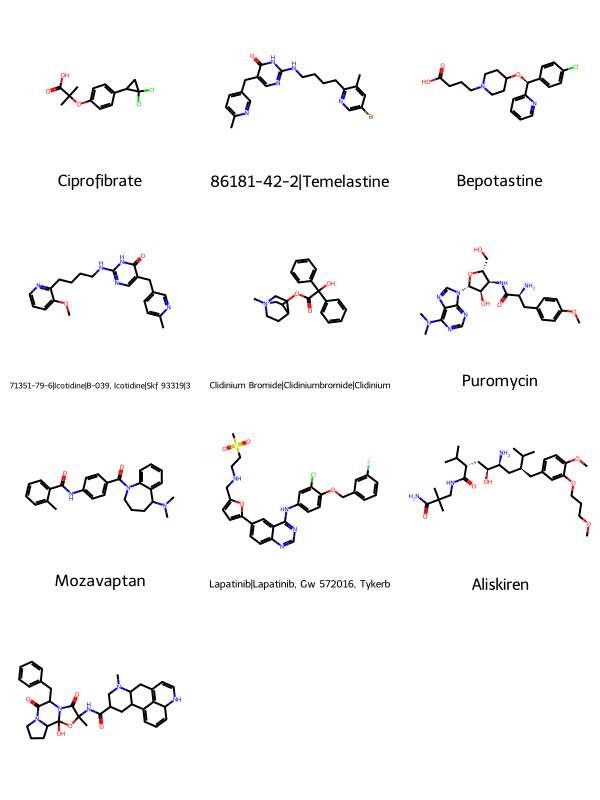

In [10]:
# Plotting sets of molecules in a particular 
from rdkit.Chem import Draw
_df = df_test[
    (df_t_o["BBB+/BBB-"]==0) &
    (df_t_o["pred_b3db"]==0) & 
    (df_t_o["pred_b3db_kc"]==1)
]  
rdkit.Chem.Draw.MolsToGridImage(_df.mol, legends=list(n if pd.notna(n) else "" for n in _df.names ))